# Benchmarks for cold-start

The idea is to compare DPP / random / mosaïque for the selection of the first items to rate for a newcomer.

## Preliminaries: DPP sampling

Load vectors from the saved SVD

In [2]:
from mangaki.utils.data import Dataset
dataset = Dataset()

In [3]:
from mangaki.utils.svd import MangakiSVD
algo = MangakiSVD()
algo.load(algo.get_backup_filename())  # Trained on everything
dataset.load('ratings-' + algo.get_backup_filename())

In [4]:
import numpy as np
rated_by_jj = np.array(User.objects.get(id=1).rating_set.values_list('work', 'work__title', 'choice'), dtype=[('work_id', 'i2'), ('work_title', 'U128'), ('choice', 'S8')])

In [5]:
rated_works = rated_by_jj['work_id']
encoded_work_ids = dataset.encode_works(rated_works)

In [6]:
vectors = algo.VT.T[encoded_work_ids]
L = vectors.dot(vectors.T)

In [7]:
D, V = np.linalg.eig(L.T)
D = np.real(D)
V = np.real(V)

If we want to summarize JJ's profile, which ratings should we keep?

In [8]:
from mangaki.utils import dpplib
sampled_indices = list(map(int, dpplib.sample_k(5, D, V)))
print(rated_by_jj[sampled_indices])
dpp_works = rated_works[sampled_indices]

def get_dpp_works(k):
    sampled_indices = list(map(int, dpplib.sample_k(k, D, V)))
    # print(rated_by_jj[sampled_indices])
    return rated_works[sampled_indices]

import random
def get_random_works(k):
    return np.array(random.sample(list(rated_works), k))

[(  34, 'K-On!', b'wontsee') (   9, 'Elfen Lied', b'willsee')
 ( 150, 'Danshi Koukousei no Nichijou', b'willsee')
 (1973, 'Fate/stay night: Unlimited Blade Works (TV) - Prologue', b'willsee')
 (1563, 'Ponyo sur la falaise', b'like')]


## Simulation

In [17]:
print(Rating.objects.filter(user_id=1).count(), 'ratings for JJ')
ds = Dataset()
anonymized = ds.make_anonymous_data(Rating.objects.all())

536 ratings for JJ


In [18]:
def select_works_to_rate():
    if METHOD == 'dpp':
        kept_works = get_dpp_works(NB_WORKS)
    else:
        kept_works = get_random_works(NB_WORKS)
    return kept_works

In [19]:
def split_train_test(kept_works):
    i_train = []
    i_test = []
    my_encoded_user_id = ds.encode_user[1]
    encoded_kept_works = set(ds.encode_works(kept_works))
    for i, (encoded_user_id, encoded_work_id) in enumerate(anonymized.X):
        if encoded_user_id == my_encoded_user_id and encoded_work_id not in encoded_kept_works:
            i_test.append(i)
        else:
            i_train.append(i)
    return i_train, i_test

In [34]:
from mangaki.utils.knn import MangakiKNN
from sklearn.metrics import mean_squared_error
def compute_error(i_train, i_test):
    knn = MangakiKNN(40)
    knn.set_parameters(anonymized.nb_users, anonymized.nb_works)
    knn.fit(anonymized.X[i_train], anonymized.y[i_train])
    my_encoded_user_id = ds.encode_user[1]
    neighbors = knn.get_neighbors([my_encoded_user_id])[0]
    # print([User.objects.get(id=user_id) for user_id in ds.decode_users(neighbors)])
    y_pred = knn.predict(anonymized.X[i_test])
    print('predicted:', y_pred[:5])
    print('was:', anonymized.y[i_test][:5])
    rmse = mean_squared_error(anonymized.y[i_test], y_pred) ** 0.5
    print('rmse:', rmse)
    top_pred_indices = y_pred.argsort()[-20:]
    # top_pred_indices = anonymized.y[i_test].argsort()[-20:]
    print('predicted:', y_pred[top_pred_indices])
    print('was:', anonymized.y[i_test][top_pred_indices])
    rmse = mean_squared_error(anonymized.y[i_test][top_pred_indices], y_pred[top_pred_indices]) ** 0.5
    print('rmse:', rmse)
    for work_id in [ds.decode_work[encoded_work_id] for _, encoded_work_id in anonymized.X[i_test][top_pred_indices]]:
        print(Work.objects.get(id=work_id).title)
    # print('full predict')
    # knn.predict(np.array([(1522, ds.encode_work[13811])]), True)
    return rmse

In [41]:
def run_simulation():
    kept_works = select_works_to_rate()
    i_train, i_test = split_train_test(kept_works)
    print('train size', len(i_train))
    print('test size', len(i_test))
    rmse = compute_error(i_train, i_test)
    print(NB_WORKS, METHOD, rmse)

## Results (number of works asked, strategy, RMSE)

- 10 DPP 1.09488816919 1.1020390692
- 20 DPP 1.0957652159900086
- 50 DPP 1.06436560838
- 100 DPP 1.0724727205
- 500 DPP 1.27818830679 0.848657862475 (possibly overfitting)

- 10 RND 1.09689215268 1.08273857127
- 20 RND 1.11930399192
- 50 RND 1.06455730002
- 100 RND 1.06357987938
- 500 RND 0.825381153284 0.754057572138

In [42]:
NB_WORKS = 10
METHOD = 'dpp'

In [43]:
run_simulation()

train size 317355
test size 526
[array([ 855,  279, 1050,  873, 1155, 1799,  103,  893, 1892,  745, 1761,
       1235,  101, 1239,  406, 1567,  634, 1441,  438, 1244, 1134, 1664,
        610,  169,  912, 1222,  129, 1687,  159,  407,  758,  593,  962,
        551, 1323,  785,  570, 1485, 1814, 1401])]
predicted: [ 0.  0.  0.  0.  0.]
was: [-0.5 -0.5 -0.5  0.5  0.5]
rmse: 1.23206181617
predicted: [ 1.14453807  1.14509658  1.15560294  1.16562679  1.20279494  1.22436833
  1.22739906  1.26143443  1.26331597  1.2685274   1.31005521  1.31468137
  1.39853659  1.42103941  1.43096924  1.6688064   1.68547088  1.70220729
  1.72033654  1.72612439]
was: [ 0.5  2.   2.  -0.5  4.   0.5  4.   2.   2.   2.   2.   0.5  0.1  4.   2.
  0.5  0.5  2.   4.   2. ]
rmse: 1.41820288426
Angel Beats!
Mahou Shoujo Madoka★Magica
Toki wo Kakeru Shoujo
Kill la Kill
Suzumiya Haruhi no Yuuutsu
Fullmetal Alchemist
Les Enfants Loups : Ame & Yuki
Code Geass: Hangyaku no Lelouch R2
Durarara!!
Nausicaä of the Valley of the 

Still needs to be done:
- run simulation on several users (how many works should be kept?)
- try a different number of neighbors
- should we evaluate the strategy on the whole profile or just the top recommendations?
- try other models than MangakiKNN (but others are slow)

## SVD

In [14]:
encoded_user_id = dataset.encode_work[1]
X_test = np.array([(encoded_user_id, dataset.encode_work[work_id]) for work_id in rated_works])

In [23]:
y_pred = algo.predict(X_test)
top_recommended = y_pred.argsort()[-10:]
for i in top_recommended:
    print(rated_by_jj[i])

(1, 'Death Note', b'like')
(13, 'Code Geass: Hangyaku no Lelouch R2', b'like')
(2, 'Code Geass: Hangyaku no Lelouch', b'neutral')
(5, "L'Attaque des Titans", b'like')
(127, 'Hunter x Hunter', b'wontsee')
(2417, "Kuroko's Basketball 2", b'willsee')
(9385, 'Parasyte -the maxim-', b'willsee')
(107, 'Kuroko no Basket', b'willsee')
(7, 'Fullmetal Alchemist: Brotherhood', b'willsee')
(46, 'Psycho-Pass', b'willsee')


In [21]:
rated_works[top_recommended], y_pred[top_recommended]

(array([   1,   13,    2,    5,  127, 2417, 9385,  107,    7,   46], dtype=int16),
 array([ 1.6811598 ,  1.76624399,  1.76966227,  1.83171241,  1.85026713,
         1.8516618 ,  1.90392899,  2.01091566,  2.07686592,  2.4513739 ]))

In [68]:
from mangaki.utils.values import rating_values
y_test = np.array(list(map(lambda x: rating_values[x.decode('utf-8')], rated_by_jj['choice'])))

In [37]:
rmse = mean_squared_error(y_test, y_pred) ** 0.5
rmse

1.3342711646750836

In [61]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=False)

In [46]:
X_reg = algo.VT.T[dataset.encode_works(rated_works)]
clf.fit(X_reg, y_test)

/Users/jin/Sites/mangaki/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [54]:
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

1.0812074357558288

In [137]:
sampled_indices = list(map(int, dpplib.sample_k(20, D, V)))
print(sampled_indices)

[22, 171, 153, 250, 373, 251, 306, 442, 272, 291, 20, 331, 200, 301, 395, 341, 286, 375, 38, 258]


In [138]:
clf = LinearRegression(fit_intercept=False)
clf.fit(X_reg[sampled_indices], y_test[sampled_indices])
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

2.9427890870750679

In [72]:
top_recommended = y_reg_pred.argsort()[-10:]
print(rated_by_jj[top_recommended])
bottom_recommended = y_reg_pred.argsort()[:10]
print(rated_by_jj[bottom_recommended])

[(  16, 'Steins;Gate', b'favorite') (  19, 'Mirai Nikki', b'willsee')
 (  46, 'Psycho-Pass', b'willsee') (  55, 'No Game No Life', b'favorite')
 (4369, "Attaque Des Titans (l')", b'willsee')
 (5001, 'Death note', b'like') (   1, 'Death Note', b'like')
 (   2, 'Code Geass: Hangyaku no Lelouch', b'neutral')
 (  13, 'Code Geass: Hangyaku no Lelouch R2', b'like')
 (   5, "L'Attaque des Titans", b'like')]
[(    8, 'Fullmetal Alchemist', b'willsee')
 (  195, 'Fullmetal Alchemist: Brotherhood OVA Collection', b'willsee')
 (   18, 'Fairy Tail', b'willsee')
 (    7, 'Fullmetal Alchemist: Brotherhood', b'willsee')
 (   17, 'Naruto: Shippuuden', b'wontsee')
 (  126, 'Dragon Ball GT', b'willsee')
 (  125, 'Fullmetal Alchemist: The Conqueror of Shamballa', b'willsee')
 (   27, 'One Piece', b'wontsee') (10505, 'Dog Days', b'willsee')
 (  844, 'Card Captor Sakura', b'favorite')]


In [100]:
sampled_indices = random.sample(range(len(rated_works)), 10)
clf = LinearRegression(fit_intercept=False)
clf.fit(X_reg[sampled_indices], y_test[sampled_indices])
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

2.3143075293148456

## Clean SVD

In [1]:
from mangaki.utils.data import Dataset
from mangaki.utils.svd import MangakiSVD
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import numpy as np
from mangaki.utils.dpp import MangakiProxyDPP
from sklearn.linear_model import LinearRegression, LogisticRegression
import random
import csv


dataset = Dataset()
# dataset.load('ratings-svd.pickle')
dataset.load_csv('ratings-ml.csv')

NB_COMPONENTS = 20
TEST_SIZE_RATE = 0.2
NB_MOST_POPULAR = 100  # None for all

In [2]:
def get_train_test_stats(dataset):
    i_train, i_test = train_test_split(range(dataset.anonymized.nb_users), test_size=TEST_SIZE_RATE)
    r_train = []
    r_test = []
    user_test_set = set(i_test)
    nb_ratings = Counter()
    for r, (encoded_user_id, encoded_work_id) in enumerate(dataset.anonymized.X):
        if encoded_user_id in user_test_set:
            r_test.append(r)
        else:
            r_train.append(r)
            nb_ratings[encoded_work_id] += 1
#    popular_encoded_work_ids = get_popular(nb_ratings, NB_MOST_POPULAR)
    print('Rating test set rate', len(r_test) / len(dataset.anonymized.X))
    return i_test, r_train, r_test, nb_ratings

In [3]:
def get_popular_subset(nb_ratings, nb_most_popular):
    return np.array([work_id for work_id, _ in nb_ratings.most_common(nb_most_popular)])

In [4]:
def get_truth_dict(dataset, r_test):
    truth = defaultdict(dict)
    for r in r_test:
        user_id, work_id = dataset.anonymized.X[r]
        truth[user_id][work_id] = dataset.anonymized.y[r]
    return truth

In [5]:
def sample_questions(method, nb_questions):
    if method == 'dpp':
        vectors = model.VT.T[work_subset]
        dpp = MangakiProxyDPP(vectors)
        sampled_indices = dpp.sample_k(nb_questions)
    else:
        sampled_indices = random.sample(list(range(len(work_subset))), nb_questions)
    return sampled_indices

In [39]:
AVERAGE_RATING = 2.5
def collect_answers(all_vectors, asked_encoded_work_ids, user_truth):
    """print(sorted(user_truth.keys())[:5])
    print(sorted(asked_encoded_work_ids)[:5])"""
    X = []
    y = []
    yl = []
    for encoded_work_id in asked_encoded_work_ids:
        choice = user_truth.get(encoded_work_id)
        if choice is not None:
            X.append(all_vectors[encoded_work_id])
            y.append(choice)
            yl.append(1 if choice > AVERAGE_RATING else -1)
    return X, y, yl

In [31]:
def validate_model(clf, all_vectors, user_truth, clf2=None):
    encoded_work_ids, true_choices = zip(*user_truth.items())
    encoded_work_ids = list(encoded_work_ids)
    pred_choices = clf.predict(all_vectors[encoded_work_ids])
    """print(pred_choices[:5])
    print(true_choices[:5])
    if clf2:
        print(clf2.predict(all_vectors[encoded_work_ids])[:5])"""
    return model.compute_rmse(pred_choices, true_choices)

In [44]:
from mangaki.utils.als import MangakiALS

model = MangakiALS(NB_COMPONENTS)
model.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
i_test, r_train, r_test, nb_ratings = get_train_test_stats(dataset)
truth = get_truth_dict(dataset, r_test)

model.fit(dataset.anonymized.X[r_train], dataset.anonymized.y[r_train])
all_vectors = model.VT.T
work_subset = get_popular_subset(nb_ratings, NB_MOST_POPULAR)

Rating test set rate 0.2077416903323867
Computing M: (671 × 9066)
Chrono: fill and center matrix [0q, 581ms]
Shapes (671, 20) (20, 9066)
Chrono: factor matrix [0q, 6409ms]


In [45]:
METHOD = 'dpp'  # 'random'
NB_QUESTIONS = 10

In [48]:
NB_QUESTIONS_VALUES = [10, 30, 50]
rmse_values = defaultdict(lambda: defaultdict(lambda: []))
c = 0
happened = 0
print(len(i_test), 'personnes à tester')
for METHOD in ['dpp', 'random']:
    for NB_QUESTIONS in NB_QUESTIONS_VALUES:
        # print(METHOD, NB_QUESTIONS, 'Q')
        for user_id in i_test:
            c += 1
            user_truth = truth[user_id]
            # print('User', user_id)
            sampled_indices = sample_questions(METHOD, NB_QUESTIONS)
            asked_encoded_work_ids = work_subset[sampled_indices]
            """print(sampled_indices)
            print(len(user_truth.keys()), 'vus')"""
            X, y, yl = collect_answers(all_vectors, asked_encoded_work_ids, user_truth)
            clf = LinearRegression(fit_intercept=False)
            clf2 = None
            if len(set(yl)) >= 2:
                happened += 1
                clf2 = LogisticRegression(fit_intercept=False)
                # clf.fit(X, y)
                clf2.fit(X, yl)
                clf.coef_ = clf2.coef_
                clf.intercept_ = 0.
            else:
                clf.coef_ = np.array([0.] * NB_COMPONENTS)
                clf.intercept_ = 0.
            rmse = validate_model(clf, all_vectors, user_truth, clf2)
            rmse_values[METHOD][NB_QUESTIONS].append(rmse)
            # print('RMSE', rmse)
        rmse_values[METHOD][NB_QUESTIONS] = np.array(rmse_values[METHOD][NB_QUESTIONS])
print('happened', happened, 'on', c, 'tries')

135 personnes à tester
happened 254 on 810 tries


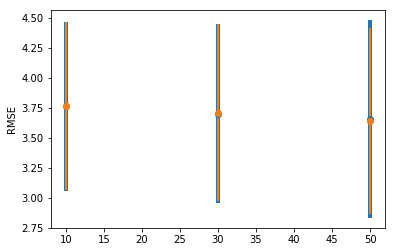

In [49]:
import matplotlib.pyplot as plt
size = {'dpp': 4, 'random': 2}
for method in rmse_values:
    plt.errorbar(x=NB_QUESTIONS_VALUES,
                 y=[rmse_values[method][nb_questions].mean() for nb_questions in NB_QUESTIONS_VALUES],
                 yerr=[1.96 * rmse_values[method][nb_questions].std() for nb_questions in NB_QUESTIONS_VALUES],
                 linewidth=size[method], fmt='o')
plt.ylabel('RMSE')
plt.show()

In [26]:
model.NB_COMPONENTS

20